In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('./test_images/kev1.jpg')
img.shape


(768, 768, 3)

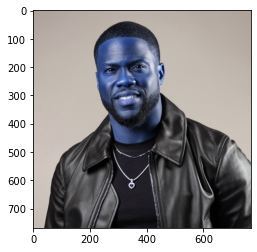

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(768, 768)

In [5]:
gray

array([[159, 159, 159, ..., 159, 159, 159],
       [159, 159, 159, ..., 160, 160, 160],
       [159, 159, 159, ..., 160, 160, 160],
       ...,
       [186, 186, 186, ...,  52,  49,  48],
       [186, 186, 186, ...,  51,  48,  46],
       [186, 186, 186, ...,  50,  48,  46]], dtype=uint8)

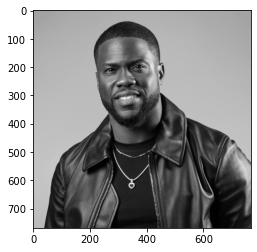

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[205, 118, 229, 229]], dtype=int32)

In [8]:
(x, y, w, h) = faces[0]
x,y,w,h

(205, 118, 229, 229)

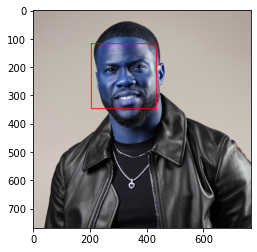

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

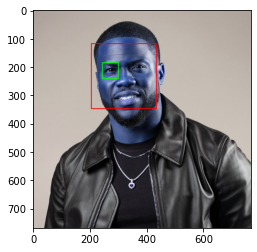

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

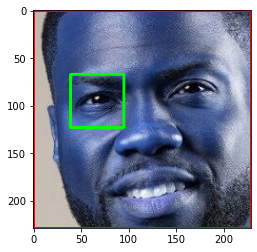

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if(img is not None):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color   
    else:
        exit(1)

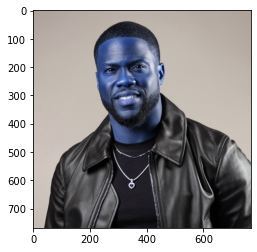

In [13]:
original_image = cv2.imread('./test_images/kev1.jpg')
plt.imshow(original_image)

In [14]:
#cropped_imagee = get_cropped_image_if_2_eyes('./test_images/kev1.jpg') - gives an error, cus it cannot see his two eyes at the sametime. Therefore this piece of code ignores it.
#plt.imshow(cropped_imagee)

In [15]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/kev1.jpg')
cropped_image_no_2_eyes # returns - 0 (zero) it cannot detect his 2nd eye, thats why

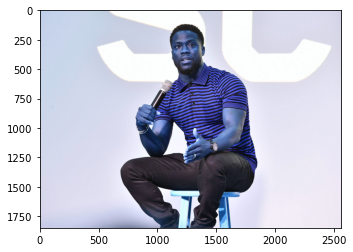

In [16]:
org_image_obstructed = cv2.imread('./test_images/kev2.jpg')
plt.imshow(org_image_obstructed)

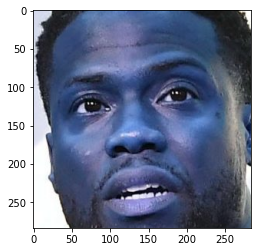

In [17]:
cropped_imagee_2 = get_cropped_image_if_2_eyes('./test_images/kev2.jpg')
plt.imshow(cropped_imagee_2)

**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

In [18]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [19]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [20]:
img_dirs

['./dataset/kevin_hart', './dataset/ricky_gervais', './dataset/dave_chappelle']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [21]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)


            cropped_file_name = celebrity_name + str(count) + ".png"                
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1
            
            # This piece of code did not work at the beginning. Therefore, I changed the inside of get_cropped_image_if_2_eyes function. Now, its ok

Generating cropped images in folder:  ./dataset/cropped/kevin_hart
Generating cropped images in folder:  ./dataset/cropped/ricky_gervais
Generating cropped images in folder:  ./dataset/cropped/dave_chappelle


## Part - 3 has completed. Also, I've deleted the unrelated images from the files by my hand in order to increase the accuracy

<h3 style='color:blue'>Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

In [23]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

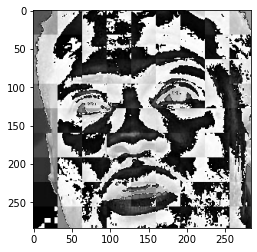

In [24]:
im_har = w2d(cropped_imagee_2,'db1',5)
plt.imshow(im_har, cmap='gray')

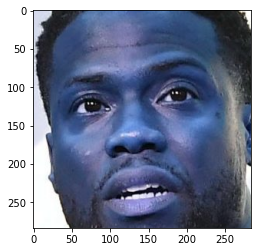

In [25]:
plt.imshow(cropped_imagee_2, cmap='gray')

In [26]:
celebrity_file_names_dict

{'kevin_hart': ['./dataset/cropped/kevin_hart/kevin_hart1.png',
  './dataset/cropped/kevin_hart/kevin_hart2.png',
  './dataset/cropped/kevin_hart/kevin_hart3.png',
  './dataset/cropped/kevin_hart/kevin_hart4.png',
  './dataset/cropped/kevin_hart/kevin_hart5.png',
  './dataset/cropped/kevin_hart/kevin_hart6.png',
  './dataset/cropped/kevin_hart/kevin_hart7.png',
  './dataset/cropped/kevin_hart/kevin_hart8.png',
  './dataset/cropped/kevin_hart/kevin_hart9.png',
  './dataset/cropped/kevin_hart/kevin_hart10.png',
  './dataset/cropped/kevin_hart/kevin_hart11.png',
  './dataset/cropped/kevin_hart/kevin_hart12.png',
  './dataset/cropped/kevin_hart/kevin_hart13.png',
  './dataset/cropped/kevin_hart/kevin_hart14.png',
  './dataset/cropped/kevin_hart/kevin_hart15.png',
  './dataset/cropped/kevin_hart/kevin_hart16.png',
  './dataset/cropped/kevin_hart/kevin_hart17.png',
  './dataset/cropped/kevin_hart/kevin_hart18.png',
  './dataset/cropped/kevin_hart/kevin_hart19.png',
  './dataset/cropped/kevin

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [27]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'kevin_hart': 0, 'ricky_gervais': 1, 'dave_chappelle': 2}

In [28]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [29]:
len(X)

139

In [30]:
len(X[0]) # 32*32*3 + 32*32

4096

In [31]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(139, 4096)

In [32]:
X[0]

array([ 34.,  38.,  37., ..., 233.,  35., 244.])

## Data Cleaning process is done. Now we're ready to train our model

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test) # it would be better if I use neural network

0.7714285714285715

In [35]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.71      0.91      0.80        11
           2       0.70      0.64      0.67        11

    accuracy                           0.77        35
   macro avg       0.77      0.77      0.77        35
weighted avg       0.78      0.77      0.77        35



### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [36]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [38]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.808571,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.654286,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.818095,{'logisticregression__C': 1}


In [39]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [40]:
best_estimators['svm'].score(X_test,y_test)

0.8285714285714286

In [41]:
best_estimators['random_forest'].score(X_test,y_test)

0.6857142857142857

In [42]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7142857142857143

In [43]:
best_clf = best_estimators['svm'] # deneyelim svmi

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[10,  1,  2],
       [ 0, 11,  0],
       [ 1,  2,  8]])

Text(69.0, 0.5, 'Truth')

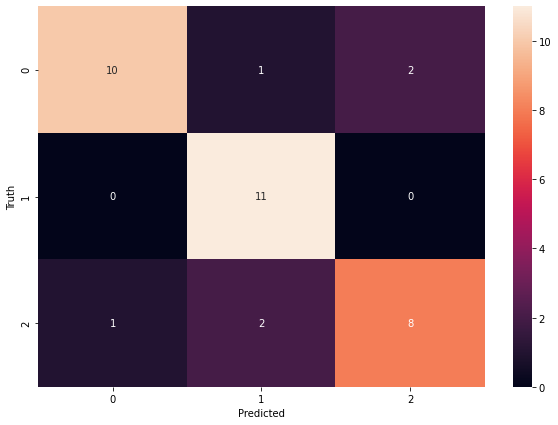

In [45]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [46]:
class_dict

{'kevin_hart': 0, 'ricky_gervais': 1, 'dave_chappelle': 2}

### Save the trained model

In [51]:
#!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [50]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))